In [59]:
%load_ext autoreload
%autoreload 2

import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf
import sys
code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)
from math import radians, cos, sin, asin, sqrt
from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

from math import radians, cos, sin, asin, sqrt

import copy
import sys

import geopandas as gpd
import numpy as np

import gpflow


code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

code_dir = '/cluster/home/kheuto01/code/opioid-overdose-models/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffSVGPPoiMC, OnOffLikelihood
gpflow.config.default_float()


from zinf_gp.metrics import normcdf, fixed_top_X


import matplotlib
matplotlib.style.use('default')
font = {
        'size'   : 22}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

data_dir='/cluster/tufts/hugheslab/datasets/NSF_OD/results_20220606_update/'

log_dir='/cluster/tufts/hugheslab/kheuto01/opioid/logs/converge/'

run_template = '{time}_{loc}_{model}_{start_year}_{cov}_{num_inducing}_{lr}'

In [6]:
time = 'annual'
loc = 'tract'
model = 'normal'
start_year = 2000
cov = '-auto'
model = 'normal'
num_inducing = '400'
lr = 0.1

In [20]:
test_years = 2
geography_col='geoid'
timestep_col='timestep'
outcome_col='deaths'

# test y always comes from quarterly tract
y_timesteps_per_year = 4
file_name = f'clean_quarter_tract'
data_path = os.path.join(data_dir, file_name)

x_idx_cols = [geography_col, 'lat','lon', timestep_col,
      'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
      'svi_pctile',
      'neighbor_t', 'self_t-1']
y_idx_cols = [geography_col, timestep_col, outcome_col]
features_only = ['lat','lon', timestep_col,
                 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc',
                 'svi_pctile',
                 'neighbor_t', 'self_t-1']

data_gdf = gpd.read_file(data_path)

last_train_year = 2018


test_y = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][y_idx_cols]
starting_y_timestep = int(test_y[timestep_col].min())

sorted_y_timesteps = test_y[timestep_col].unique()
sorted_y_timesteps.sort()

x_timesteps_per_year = {'quarter':4, 'semi':2,'annual':1}[time]

file_name = f'clean_{time}_{loc}'
data_path = os.path.join(data_dir, file_name)

data_gdf = gpd.read_file(data_path)

train_x = data_gdf[(data_gdf['year'] <= last_train_year) &
                   (data_gdf['year'] >= start_year)][x_idx_cols]
train_y = data_gdf[(data_gdf['year'] <= last_train_year) &
                   (data_gdf['year'] >= start_year)][y_idx_cols]

test_x = data_gdf[(data_gdf['year'] > last_train_year) &
                  (data_gdf['year'] <= last_train_year+test_years)][x_idx_cols]

starting_x_timestep = int(test_x[timestep_col].min())

test_timesteps_per_year = max(y_timesteps_per_year, x_timesteps_per_year)
test_timesteps = test_timesteps_per_year*test_years

x_repeats = int(test_timesteps_per_year/x_timesteps_per_year)
y_repeats = int(test_timesteps_per_year/y_timesteps_per_year)

sorted_x_timesteps = test_x[timestep_col].unique()
sorted_x_timesteps.sort()

x_timesteps = [timestep  for timestep in sorted_x_timesteps for _ in range(x_repeats)]

y_timesteps = [timestep  for timestep in sorted_y_timesteps for _ in range(y_repeats)]



In [7]:
this_run = run_template.format(time=time,loc=loc,model=model,start_year=start_year,
                                                           cov=cov,
                                                           num_inducing=num_inducing,lr=lr)

In [10]:
with open(os.path.join(log_dir,this_run,'model.mod'),'rb') as f:
        predictor = pickle.load(f)
with open(os.path.join(log_dir,this_run,'stats.csv'),'rb') as f:
    stats = pd.read_csv(f)

2023-02-23 16:56:38.838615: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-23 16:56:38.838657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2023-02-23 16:56:38.838665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p1cmp078.pax.tufts.edu
2023-02-23 16:56:38.838785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2023-02-23 16:56:38.838822: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2023-02-23 16:56:38.838828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2023-02-23 16:56:38.839303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the fo

In [48]:
data_gdf.loc[:, 'is_zero'] = data_gdf['deaths']==0
sparsity = data_gdf.groupby('year').mean()['is_zero']
deaths= data_gdf.groupby('year').sum()['deaths']
by_year_gdf = pd.concat([sparsity,deaths],axis=1)

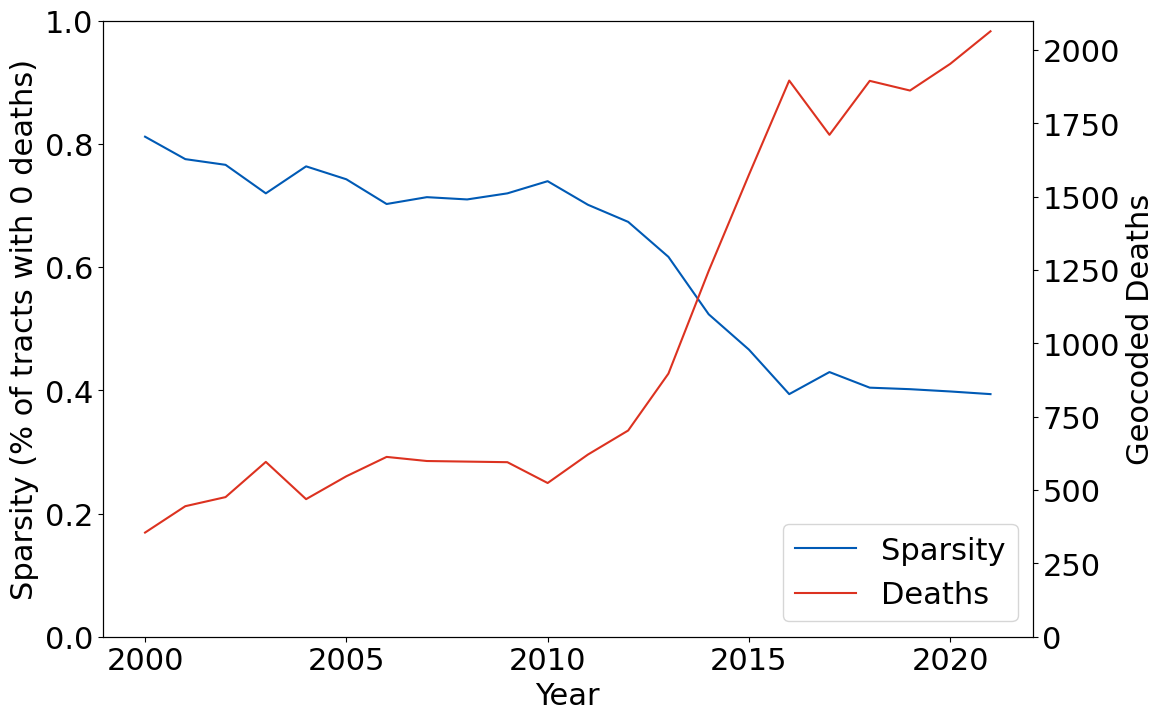

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

line_1 = ax1.plot(by_year_gdf.index, by_year_gdf.is_zero,
         label='Sparsity', color='#005AB5')
ax1.set_ylim(0,1)
ax1.set_ylabel('Sparsity (% of tracts with 0 deaths)')

line_2 = ax2.plot(by_year_gdf.index, by_year_gdf.deaths, label='Deaths', color='#DC3220');
ax2.set_ylim(0,2100)
ax2.set_ylabel('Geocoded Deaths')
ax1.set_xlabel('Year')

# added these three lines
lines=line_1+line_2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='lower right')

plt.savefig('SparsityAndDeaths.png')


In [54]:
by_year_gdf

,is_zero,deaths
year,,
2000,0.811728,355.0
2001,0.775309,445.0
2002,0.766049,476.0
2003,0.719753,596.0
2004,0.763580,469.0
2005,0.742593,547.0
2006,0.702469,613.0
2007,0.713580,599.0
2008,0.709877,597.0


In [21]:
train_x

,geoid,lat,lon,timestep,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,neighbor_t,self_t-1
0,25001010100,42.059829,-70.200407,0.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
1,25001010100,42.059829,-70.200407,1.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
2,25001010100,42.059829,-70.200407,2.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
3,25001010100,42.059829,-70.200407,3.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
4,25001010100,42.059829,-70.200407,4.0,0.7270,0.2972,0.5268,0.6872,0.6230,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35632,25027761402,42.531342,-71.592751,14.0,0.3794,0.3189,0.4701,0.2374,0.3199,0.125,0.0
35633,25027761402,42.531342,-71.592751,15.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.000,0.0
35634,25027761402,42.531342,-71.592751,16.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.000,0.0
35635,25027761402,42.531342,-71.592751,17.0,0.1522,0.2139,0.3928,0.1570,0.1229,0.125,0.0


In [22]:
x_repeats

4

In [23]:
y_repeats

1

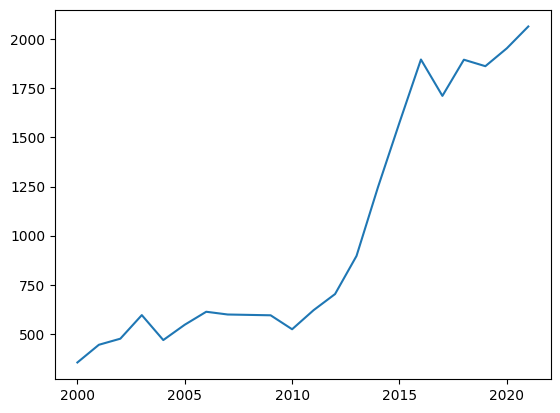

In [34]:
plt.plot(data_gdf.year.unique(), data_gdf.groupby('year').sum()['deaths'])

year
2000    0.811728
2001    0.775309
2002    0.766049
2003    0.719753
2004    0.763580
2005    0.742593
2006    0.702469
2007    0.713580
2008    0.709877
2009    0.719753
2010    0.739506
2011    0.701235
2012    0.673457
2013    0.616667
2014    0.523457
2015    0.466049
2016    0.393827
2017    0.429630
2018    0.404321
2019    0.401852
2020    0.398148
2021    0.393827
Name: is_zero, dtype: float64